# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print('Data loaded successfully.')

Data loaded successfully.


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

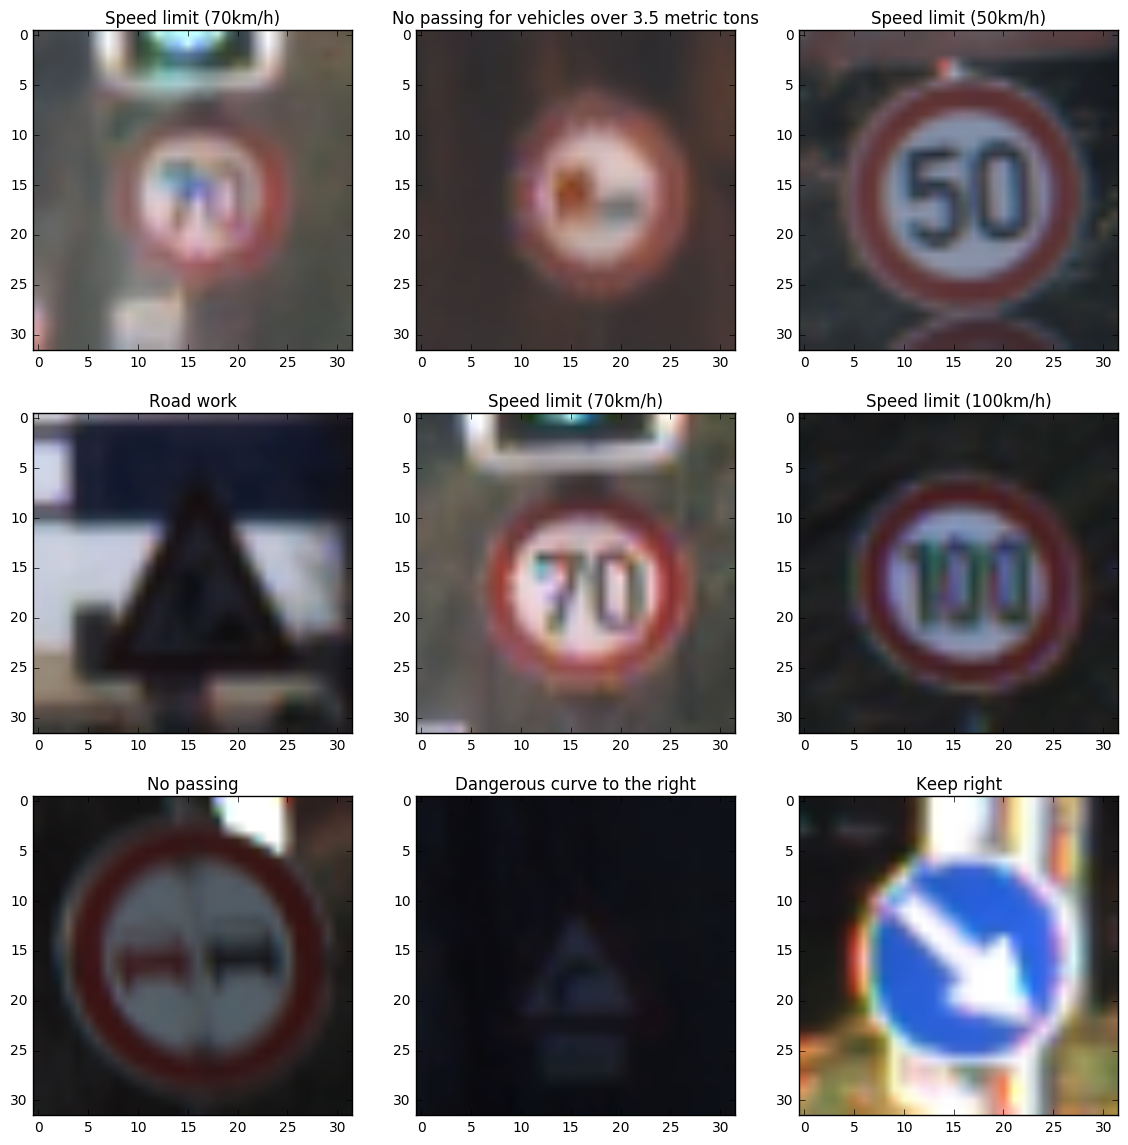

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import csv
import matplotlib.image as mpimg

reader = csv.DictReader(open('signnames.csv'))

signnames = {}
for row in reader:
    key = row.pop('ClassId')
    if key in signnames:
        pass
    signnames[key] = row

# Get random images from the training set:
plt.figure(figsize=(14, 14))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img = np.random.randint(2, high=n_train)
    plt.imshow(X_train[img, :, :, :]) 
    plt.title( signnames[ str(y_train[img]) ]['SignName'] )

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
print('Preprocessing complete.')

Preprocessing complete.


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** So far I chose not to add additional data until testing. However, shuffling the training set is important to avoid getting stuck in local minimums.

In [5]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split
# Data split into sets:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
print('Data split into training, validation and testing sets.')

Data split into training, validation and testing sets.


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** I kept the test data as-is since we already have it, but I chose to split the training and validation data into two separate sets with 20% of the data going into validation, following advice from the 'LeNet for Traffic Signs' video in the classroom and from the later labs (Keras).

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

EPOCHS = 60
BATCH_SIZE = 256

from tensorflow.contrib.layers import flatten

def LeNet(x):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # ReLU Activation:
    conv1 = tf.nn.relu(conv1)

    # Pooling: Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout:   
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # ReLU Activation:
    conv2 = tf.nn.relu(conv2)

    # Pooling: Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout:   
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Flatten: Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # ReLU Activation:
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # ReLU Activation:
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43. (Traffic sign classes) 
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) 
one_hot_y = tf.one_hot(y, 43)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** I used the implementation of LeNet from the classroom as-is at first, but then decided to add dropout layers after each convolution layer to see if that would help in improving the model's accuracy.

In [7]:
# Training Pipeline:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [8]:
# Model Evaluation:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(
            accuracy_operation,
            feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: 1.0 # For full power of the network, disables dropout layers
            })
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [9]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Actual model training:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.70})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.106

EPOCH 2 ...
Validation Accuracy = 0.230

EPOCH 3 ...
Validation Accuracy = 0.349

EPOCH 4 ...
Validation Accuracy = 0.441

EPOCH 5 ...
Validation Accuracy = 0.497

EPOCH 6 ...
Validation Accuracy = 0.548

EPOCH 7 ...
Validation Accuracy = 0.603

EPOCH 8 ...
Validation Accuracy = 0.657

EPOCH 9 ...
Validation Accuracy = 0.705

EPOCH 10 ...
Validation Accuracy = 0.719

EPOCH 11 ...
Validation Accuracy = 0.758

EPOCH 12 ...
Validation Accuracy = 0.778

EPOCH 13 ...
Validation Accuracy = 0.789

EPOCH 14 ...
Validation Accuracy = 0.816

EPOCH 15 ...
Validation Accuracy = 0.839

EPOCH 16 ...
Validation Accuracy = 0.842

EPOCH 17 ...
Validation Accuracy = 0.867

EPOCH 18 ...
Validation Accuracy = 0.884

EPOCH 19 ...
Validation Accuracy = 0.889

EPOCH 20 ...
Validation Accuracy = 0.898

EPOCH 21 ...
Validation Accuracy = 0.911

EPOCH 22 ...
Validation Accuracy = 0.921

EPOCH 23 ...
Validation Accuracy = 0.908

EPOCH 24 ...
Validation Accura

#### Testing on test set
Now, to answer question 7 below, we would need to test the model with the testing set we split earlier. This is only done once the model has been finalized: 

In [12]:
# WARNING: Only run this once. Do not modify the model after running as it invalidates the test.
with tf.Session() as sess:    
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.906


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** At first I left the same hyperparameters as the LeNet lab in order to start improving the model. 

The first run with an unmodified model (10 epochs, 128 batch size, mu = 0, sigma = 0.1 and learning rate = 0.001) achieved a validation accuracy of 0.958. Increasing the epochs to 100 proved to not be the proper course of action, because even though it achieved a higher overall accuracy (maxed at 0.986) it did so while jumping back and forth through lower accuracy numbers.

Adding the dropout layers made the final validation accuracy go down dramatically, requiring an increase in epochs to 6 times as much (without increasing the number of samples by jittering or otherwise), but increasing the keep probability of the dropout layer from the recommended starting value of 0.50 to 0.70 caused it to improve (Increasing the keep prob. to 0.75 also increased the validation accuracy to 0.986 -the highest accuracy on the model with no dropout- but it seems to me like it is overfitting the data.)

I also doubled the batch size to speed up each epoch calculation. In the end, I managed to achieve a 0.974 training accuracy with this model.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** When I first started to work on the problem, the LeNet labs weren't available in the classroom, but I was curious to see how to implement it and tried to focus on that. While working on other labs and coming back to this problem, it became apparent that the classroom labs and most of my classmates had also chosen LeNet as the best architecture to use, so in order to save time and continue work on the rest of the Nanodegree, it felt like the obvious choice.

Of course, I wonder if adding any more dropout layers, adding more samples, or changing the overall layout of the network would achieve much higher accuracy results, but further testing would be needed to confirm it.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Test images loaded.


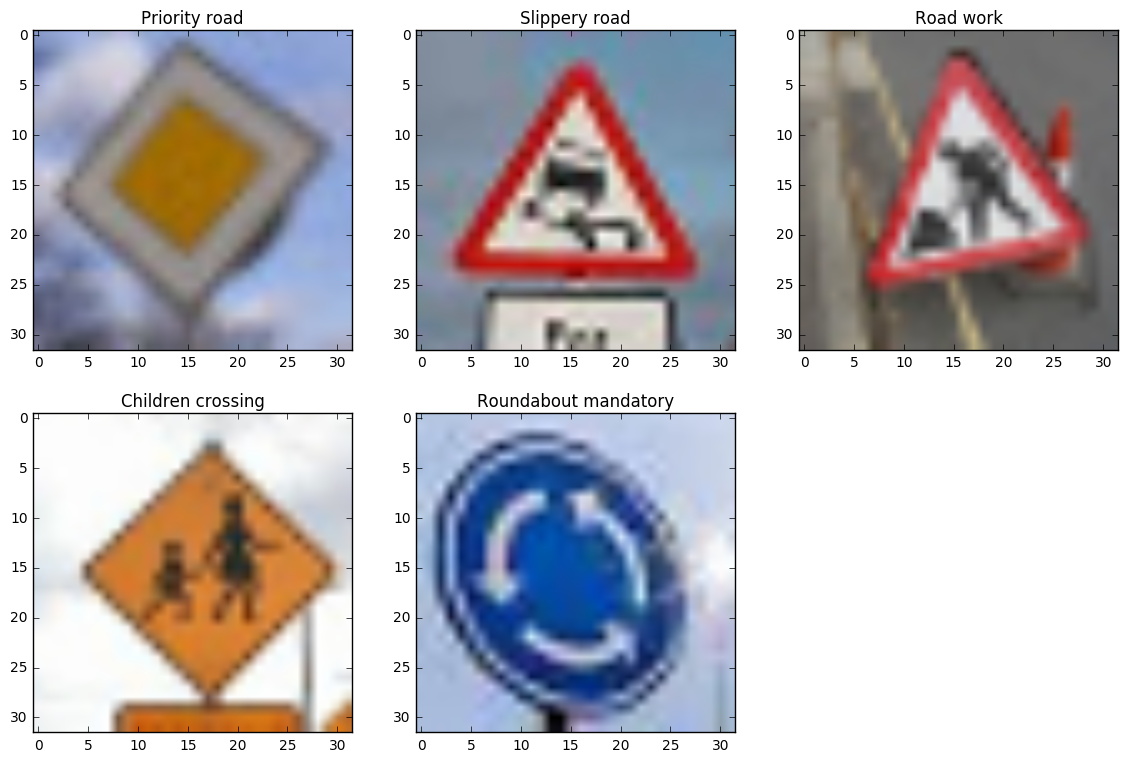

In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# Initialize test images and labels arrays:
X_new = np.zeros((5,32,32,3))
y_new = [12,23,25,28,40]

import matplotlib.image as mpimg

# Load the images and plot them:
plt.figure(figsize=(14, 14))
for i in range(1,6):
    image = mpimg.imread('./test_images/'+ str(i) + '.jpg')
    plt.subplot(3, 3, i)
    plt.imshow(image)
    plt.title( signnames[ str(y_new[i-1]) ]['SignName'] )
    X_new[i-1] = image
print('Test images loaded.')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** For images, I generated five random numbers and looked up the corresponding label in the CSV file. These are:

12: 'Priority Road',
23: 'Slippery Road',
25: 'Road work',
28: 'Children crossing' and
40: 'Roundabout mandatory'

Then, I looked up at least two examples of each image and selected one at random, resizing them to 32x32 as needed by the model.

In [11]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

# Restoring the saved model to test on new images:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Recalculate logits with new test data:
    logits = sess.run(logits, feed_dict={x: X_new, y: y_new, keep_prob: 1.0})
    captured_labels = np.argmax(logits,axis=1)
    # Print the results:
    for index, label in enumerate(captured_labels):
        print("Image was of a '{}' and model detected a '{}'".format(
                signnames[ str(y_new[index]) ]['SignName'],
                signnames[ str(label) ]['SignName'])
             )

Image was of a 'Priority road' and model detected a 'Priority road'
Image was of a 'Slippery road' and model detected a 'Slippery road'
Image was of a 'Road work' and model detected a 'Children crossing'
Image was of a 'Children crossing' and model detected a 'Stop'
Image was of a 'Roundabout mandatory' and model detected a 'Roundabout mandatory'


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** The model managed to predict 3 out of 5 test traffic signs correctly (60% accuracy), while testing on the test set the model scored an accuracy of 90.6%. 

In [17]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

softmax = tf.nn.softmax(logits)
top_k = (tf.nn.top_k(softmax, k=5))

with tf.Session() as sess:    
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    softmax = sess.run(softmax, feed_dict={x: X_new, y: y_new, keep_prob: 1.0})
    print('Softmax values:')
    print(softmax)
    
with tf.Session() as sess:    
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    top_k = sess.run(top_k, feed_dict={x: X_new, y: y_new, keep_prob: 1.0})
    print('Top K values:')
    print(top_k)

Softmax values:
[[  8.80617058e-14   2.11812323e-09   4.61895328e-10   1.64688832e-10
    4.18193791e-09   1.04152423e-10   3.09061824e-15   5.30686710e-11
    2.28171620e-10   9.81653439e-11   6.63451022e-12   3.15813015e-10
    9.99789178e-01   6.35899444e-10   4.20023844e-06   1.15750074e-13
    7.92323288e-17   2.06672310e-04   2.10561871e-14   9.71241462e-17
    5.99492678e-11   9.41056694e-12   1.00236363e-14   1.36243600e-10
    1.00930311e-13   1.52635792e-12   8.84218778e-14   3.22217653e-17
    5.03874997e-11   8.33965075e-09   6.45344780e-13   1.04615366e-13
    1.29799780e-08   1.34602116e-14   3.04799019e-10   3.05217171e-11
    1.35099627e-13   9.56742560e-16   2.90130160e-08   4.48951243e-19
    1.90336757e-14   8.96690491e-13   2.74891620e-11]
 [  2.05521428e-04   4.90446226e-04   1.27270119e-04   4.16497962e-04
    1.03451919e-06   1.44614198e-03   1.04623350e-14   5.31003707e-06
    1.55729981e-06   3.10070282e-05   2.83283669e-07   9.78475884e-02
    1.26358545e-05  

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** For the test images I used, the model was very certain of the ones it successfully recognized, with those being images 1, 2, and 5 (with close to 100% certainty, according to their highest probabilities on top_k). For images 3 and 4, which had class ids of 25 and 28 respectively, the model was only barely certain of image 3 (class id 25) with a probability of 3.25815257e-04.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.